<a href="https://colab.research.google.com/github/cabb1808/miniproyecto1/blob/main/miniproyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Descargar datos de GIT
!wget 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'


--2023-03-21 03:13:49--  https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.4’

housing.csv.4       100%[===================>]   1.36M  --.-KB/s    in 0.02s   

2023-03-21 03:13:49 (68.3 MB/s) - ‘housing.csv.4’ saved [1423529/1423529]



In [50]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc


In [52]:
ruta_Sismo = 'https://drive.google.com/file/d/1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI/view?usp=sharing'
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisLoc.mat' # sismo regional
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisReg.mat' # sismo regional
!gdown  "1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t" -O 'sisTele.mat' # sismo regional

Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisLoc.mat
100% 1.55M/1.55M [00:00<00:00, 172MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisReg.mat
100% 1.55M/1.55M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p5QZOtKzF_THvpt6N46ypi4PkBHM12QI&confirm=t
To: /content/sisTele.mat
100% 1.55M/1.55M [00:00<00:00, 144MB/s]


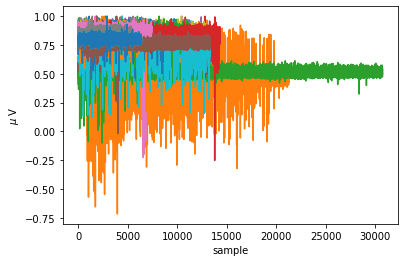

In [96]:
data_local = sc.loadmat('sisLoc.mat')
data_regio = sc.loadmat('sisReg.mat')
data_tele = sc.loadmat('sisTele.mat')

data_local.keys() # variables del diccionario

Y = data_local['Y']
fs = data_local['fs'][0][0]


#Eliminar valores en cero
Y_L=[]
for i in range(len(Y)):
  if Y[i][-1] == 0:
    c=0
    for j in range(1,len(Y[i])):
      if Y[i][-j] != 0:
        break
      else: 
        c=c+1
    Y_L.append(Y[i][0:(len(Y[i])-c)])
  else: 
    Y_L.append(Y[i][:])



for i in range(len(Y_L)):
  plt.plot(Y_L[i].T)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.show()

In [97]:
@interact(idx = (0,20,1))

def plotSismos(idx):
  
  sampleSignal = Y_L[idx][:] # se extrae una señal de la base de datos
  plt.figure
  plt.plot(sampleSignal)
  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

interactive(children=(IntSlider(value=10, description='idx', max=20), Output()), _dom_classes=('widget-interac…

In [ ]:
# Agregar filtro

In [98]:
# We decompose the time series into three subseries
X_L = Y_L # Conjunto de 21 sismos
groups = 3
# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=groups)
X_ssa = ssa.fit_transform(X_L)

# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))
idSignal = 3
ax1 = plt.subplot(121)
ax1.plot(X[idSignal], 'o-', label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)

for i in range(groups):
    ax2.plot(X_ssa[idSignal, i], 'o--', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# The first subseries consists of the trend of the original time series.
# The second and third subseries consist of noise.

ValueError: ignored

In [91]:
from ipywidgets import interact

In [92]:
@interact(idx = (0,20,1))

def plotSismos(idx):
  
  sampleSignal = Y[idx,:] # se extrae una señal de la base de datos
  plt.figure
  plt.plot(sampleSignal)
  plt.xlabel('sample')
  plt.ylabel('$\mu$ V')
  plt.show()

interactive(children=(IntSlider(value=10, description='idx', max=20), Output()), _dom_classes=('widget-interac…